# Working with several networks

When one single network isn't enough.

---

- Website: https://discovery.gitlabpages.inria.fr/enoslib/index.html
- Instant chat: https://framateam.org/enoslib
- Source code: https://gitlab.inria.fr/discovery/enoslib

---

**Prerequisites:**
- A Grid'5000 account
- A working EnOSlib environment and Jupyter (not included in EnOSlib dependencies, but `pip install jupyterlab` will install it)




## Setup

In [1]:
import enoslib as en

# get some logging info
import logging
logging.basicConfig(level=logging.INFO)

We reserve two nodes (with at least two network interfaces), the first network interface of each node will use the production network of Grid'5000 (not isolated network) while a second network interface will be configured to use a Vlan.

- To find out which machine have at least two network cards, you can refer to the [hardware page of Grid'5000](https://www.grid5000.fr/w/Hardware)
- To know more about Vlans on Grid'5000, you can refer to this [page](https://www.grid5000.fr/w/KaVLAN)

<div class="alert alert-block alert-warning">
Beware: the number of VLAN is limited. Here we want a routed vlans and there are only 6 routed vlan per sites (3 are monosite and 3 are multisite) 
</div>

In [2]:
SITE = "rennes"

network = en.G5kNetworkConf(id="n1", type="prod", roles=["public"], site=SITE)
private = en.G5kNetworkConf(id="n2", type="kavlan", roles=["private"], site=SITE)

conf = (
    en.G5kConf.from_settings(job_name="enoslib_several_networks")
        .add_network_conf(network)
        .add_network_conf(private)
        .add_machine(
            roles=["server", "xp"],
            cluster="paravance",
            nodes=1,
            primary_network=network,
            secondary_networks=[private],
        )
        .add_machine(
            roles=["client", "xp"],
            cluster="paranoia",
            nodes=1,
            primary_network=network,
            secondary_networks=[private],
        )
        .finalize()
)
conf

Conf@0x7f9e6f9c0890
{
    "dhcp": true,
    "force_deploy": false,
    "env_name": "debian10-x64-nfs",
    "job_name": "enoslib_several_networks",
    "job_type": [
        "deploy"
    ],
    "key": "/home/msimonin/.ssh/id_rsa.pub",
    "queue": "default",
    "walltime": "02:00:00",
    "resources": {
        "machines": [
            {
                "roles": [
                    "server",
                    "xp"
                ],
                "primary_network": "n1",
                "secondary_networks": [
                    "n2"
                ],
                "cluster": "paravance",
                "nodes": 1
            },
            {
                "roles": [
                    "client",
                    "xp"
                ],
                "primary_network": "n1",
                "secondary_networks": [
                    "n2"
                ],
                "cluster": "paranoia",
                "nodes": 1
            }
        ],
        "networks": [
            {
                "id": "n1",
                "type": "prod",
                "roles": [
                    "public"
                ],
                "site": "rennes"
            },
            {
                "id": "n2",
                "type": "kavlan",
                "roles": [
                    "private"
                ],
                "site": "rennes"
            }
        ]
    }
}

In [3]:
provider = en.G5k(conf)
roles, networks = provider.init()
roles

INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from grenoble
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from lille
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from luxembourg
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from lyon
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from nancy
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from nantes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from sophia
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Submitting {'name': 'enoslib_several_networks', 'types': ['deploy'], 'resources': "{cluster='paravance'}/nodes=1+{cluster='paranoia'}/nodes=1+{type='kavlan'}/vlan=1,walltime=02:00:00", 'command': 'sleep 31536000', 'queue': 'default'} on rennes


Waiting for the end of deployment [D-8e110e7e-e3aa-4ec3-bfe6-3199dcb3816b]
Waiting for the end of deployment [D-8e110e7e-e3aa-4ec3-bfe6-3199dcb3816b]
Waiting for the end of deployment [D-8e110e7e-e3aa-4ec3-bfe6-3199dcb3816b]
Waiting for the end of deployment [D-8e110e7e-e3aa-4ec3-bfe6-3199dcb3816b]
Waiting for the end of deployment [D-8e110e7e-e3aa-4ec3-bfe6-3199dcb3816b]
Waiting for the end of deployment [D-8e110e7e-e3aa-4ec3-bfe6-3199dcb3816b]
Waiting for the end of deployment [D-8e110e7e-e3aa-4ec3-bfe6-3199dcb3816b]
Waiting for the end of deployment [D-8e110e7e-e3aa-4ec3-bfe6-3199dcb3816b]
Waiting for the end of deployment [D-8e110e7e-e3aa-4ec3-bfe6-3199dcb3816b]
Waiting for the end of deployment [D-8e110e7e-e3aa-4ec3-bfe6-3199dcb3816b]
Waiting for the end of deployment [D-8e110e7e-e3aa-4ec3-bfe6-3199dcb3816b]
Waiting for the end of deployment [D-8e110e7e-e3aa-4ec3-bfe6-3199dcb3816b]
Waiting for the end of deployment [D-8e110e7e-e3aa-4ec3-bfe6-3199dcb3816b]
Waiting for the end of de

INFO:enoslib.infra.enos_g5k.g5k_api_utils:Deploying [] with options {'environment': 'debian10-x64-nfs', 'key': 'ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAAEAADfNo+lX5Wb8inFG8/N/OiwaDz29Lwc7N/nZ2DpZOJsP+gCUXtVI1dEt6RMMWn0NzD92Lg23eYd0E8cIbVyEeuODj94ClwPFxtca2nzrYd9holkhT0kS6vl6DRxhRd7jvKVYvc56GrvCGtupNi1lwboiL4yxKDs1rBxMDtbY9tvwGdBfcCWxLVxwMhU9EwyhbVTIY2H5bA6mcIQ8kmfXUnOw7Isq3tcg+fzGxPpo5M53SLVNz1x52uBmbgdMmYHpnlkuiv18ySYnZPYrU22MZjhD7AAMqtdgsNdBAOudRbMr63iDZ+9ApQkeIFsQLQXn/3p9phtBlKqkQR2uJ5NkuvzjxA27iIt7NPjjLBEPOknOSwXYcBTWBqATRJRecwot2+FicgeqY88ngQiXk5r+k2hZ/PSiieWAyWtgRgFBjP1uEO4huROt12BE6B4QltJJhxKj6tq6II4ZXOSUqIQU0oRoNSWvvdU4llgB0UcOZyEryITGjxeWs7d9kpP+dbPF+QKTAWo414mHO6oo9CtyjGDbChf1xTDt0Poy34+5/WW3TeRft7PRRVQu7nyu3v2paf0bp+1cdDUVhz3DO4385MYSUInHhkeNzkujjd6Inmb/TSbGD+m6WXYHTU04XNmN1KYK17t/VRauMF7dPFLtjTd/r2LWW0M+jz45TQoD+2TOMyOWYX33GnZwGdHOHcklBWcK8hntqg4wz5+f/+cA9Cue1Ny993XzpNd2jhcxODDNqOmUuaNJ1bS4EOP8HrNPRB8G7+PaPgAaIgzaBFGPmjhFs3uGCItaYircr0n8KK6hiqte0eAQvWMpd327QH28EsBGeQ+c9bdoAsxJyg2

{'server': [Host(address='paravance-6.rennes.grid5000.fr', alias='paravance-6.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())], 'xp': [Host(address='paravance-6.rennes.grid5000.fr', alias='paravance-6.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set()), Host(address='paranoia-7.rennes.grid5000.fr', alias='paranoia-7.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())], 'client': [Host(address='paranoia-7.rennes.grid5000.fr', alias='paranoia-7.rennes.grid5000.fr', user='root', keyfile=None, port=None, extra={}, net_devices=set())]}

## Get the network information of your nodes

First we retrieve the network information by syncing the Host descriptions with the remote machines.
Syncing the information will populate every single Host datastructure with some actual information (e.g. number of cores, network information).
This relies on Ansible fact gathering and is provider agnostic. 
Note that Grid'5000 provides a lot of node information in its [REST API](https://api.grid5000.fr) (but provides only static information)

In [4]:
roles = en.sync_info(roles, networks)
roles

[WARNING]: No inventory was parsed, only implicit localhost is available



PLAY [all] **********************************************************************************************************************************************************************************

TASK [hostname] *****************************************************************************************************************************************************************************
 [started TASK: hostname on paravance-6.rennes.grid5000.fr]
 [started TASK: hostname on paranoia-7.rennes.grid5000.fr]
changed: [paravance-6.rennes.grid5000.fr]
changed: [paranoia-7.rennes.grid5000.fr]

PLAY [Gather facts for all hosts] ***********************************************************************************************************************************************************

TASK [Gathering Facts] **********************************************************************************************************************************************************************
ok: [paravance-6.rennes.grid5000.f

ip
fe80::eef4:bbff:fed0:f872/64
10.24.6.6/18
ip
fe80::eef4:bbff:fed0:f870/64
172.16.96.6/20
ip
::1/128
127.0.0.1/8
ip
fe80::eef4:bbff:fed0:f872/64


We can now filter the network addresses of the nodes given a network

In [5]:
server = roles["server"][0]
server.filter_addresses(networks=networks["private"])

[IPAddress(network=<enoslib.infra.enos_g5k.objects.G5kEnosVlan4Network object at 0x7f9e6f102c10>, ip=IPv4Interface('10.24.6.6/18'))]

In [6]:
ip_address = server.filter_addresses(networks=networks["private"])[0]
str(ip_address.ip.ip)

'10.24.6.6'

In [7]:
server.filter_addresses(networks=networks["public"])

[IPAddress(network=<enoslib.infra.enos_g5k.objects.G5kEnosProd4Network object at 0x7f9e6f9b82d0>, ip=IPv4Interface('172.16.96.6/20'))]

## A simple load generation tool

We are using [flent](https://flent.org/), a convenient client to netperf that is able to play different network benchmarks.

Roughly speaking, Flent connects to a Netperf server, starts a benchmark and collect metrics in various format (csv, images ... ).
That makes a good candidates when you need to get a quick insight into the performance of the network between your nodes

The goal of this part is to initiate a benchmark of TCP traffic on the `private` network. So we need to instruct `flent` to connect to the `netperf` server on the relevant address.

In [8]:
with en.actions(roles=roles) as a:
    a.apt_repository(
        repo="deb http://deb.debian.org/debian stretch main contrib non-free",
        state="present",
    )
    a.apt(
        name=["flent", "netperf", "python3-setuptools", "python3-matplotlib"],
        state="present",
    )


PLAY [all] **********************************************************************************************************************************************************************************

TASK [apt_repository] ***********************************************************************************************************************************************************************
 [started TASK: apt_repository on paravance-6.rennes.grid5000.fr]
 [started TASK: apt_repository on paranoia-7.rennes.grid5000.fr]
changed: [paravance-6.rennes.grid5000.fr]
changed: [paranoia-7.rennes.grid5000.fr]

TASK [apt] **********************************************************************************************************************************************************************************
 [started TASK: apt on paravance-6.rennes.grid5000.fr]
 [started TASK: apt on paranoia-7.rennes.grid5000.fr]
changed: [paravance-6.rennes.grid5000.fr]
changed: [paranoia-7.rennes.grid5000.fr]


---
Checking the routes on the nodes. Make sure the `private` network goes through the `private` interface.

In [9]:
routes = en.run_command("ip route list", roles=roles)
print("\n-Routes-\n")
print("\n\n".join([f"{r.host} => {r.stdout}" for r in routes]))


PLAY [all] **********************************************************************************************************************************************************************************

TASK [ip route list] ************************************************************************************************************************************************************************
 [started TASK: ip route list on paravance-6.rennes.grid5000.fr]
 [started TASK: ip route list on paranoia-7.rennes.grid5000.fr]
changed: [paravance-6.rennes.grid5000.fr]
changed: [paranoia-7.rennes.grid5000.fr]

-Routes-

paravance-6.rennes.grid5000.fr => default via 172.16.111.254 dev eno1 
10.24.0.0/18 dev eno2 proto kernel scope link src 10.24.6.6 
172.16.96.0/20 dev eno1 proto kernel scope link src 172.16.96.6 

paranoia-7.rennes.grid5000.fr => default via 172.16.111.254 dev enp3s0f0 
10.24.0.0/18 dev enp3s0f1 proto kernel scope link src 10.24.4.7 
172.16.96.0/20 dev enp3s0f0 proto kernel scope link src 17

In [10]:
server_address = str(server.filter_addresses(networks=networks["private"])[0].ip.ip)

with en.actions(pattern_hosts="server", roles=roles) as a:
    a.shell("netperf", background=True) # this is somehow idempotent .. will fail silently if netperf is already started
    a.wait_for(port=12865, state="started", task_name="Waiting for netperf to be ready")
    

with en.actions(pattern_hosts="client", roles=roles) as a:
    a.shell(
        " flent tcp_upload -p totals "
        " -l 60 "
        f" -H { server_address } "
        " -t 'tcp_upload test' "
        " -o result.png"
    )
    a.fetch(src="result.png", dest="result")


PLAY [server] *******************************************************************************************************************************************************************************

TASK [netperf] ******************************************************************************************************************************************************************************
 [started TASK: netperf on paravance-6.rennes.grid5000.fr]
changed: [paravance-6.rennes.grid5000.fr]

TASK [Waiting for netperf to be ready] ******************************************************************************************************************************************************
 [started TASK: Waiting for netperf to be ready on paravance-6.rennes.grid5000.fr]
ok: [paravance-6.rennes.grid5000.fr]

PLAY [client] *******************************************************************************************************************************************************************************

TASK [flent tc

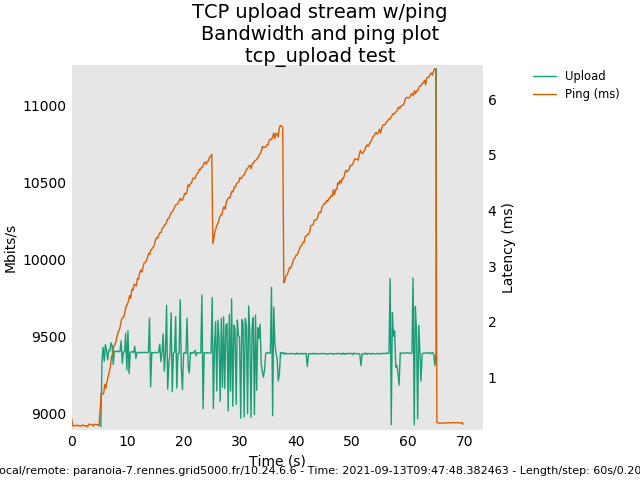

In [12]:
from IPython.display import Image
Image(f"result/{roles['client'][0].alias}/result.png")

---
Forcing the flent client to be bound on the right network (not really necessary if the routes are set correctly).
It's an opportunity to use host variables so let's do it ;)

`flent` has an option for this `--local-bind <ip>`

In [13]:
for h in roles["client"]:
    h.extra.update({"local_bind": h.filter_addresses(networks=networks["private"])[0].ip.ip})
roles["client"][0]

ip
::1/128
127.0.0.1/8
ip
fe80::a236:9fff:fe28:a914/64
172.16.100.7/20
ip
fe80::a236:9fff:fe28:a916/64
10.24.4.7/18


In [14]:
server_address = str(server.filter_addresses(networks=networks["private"])[0].ip.ip)

with en.actions(pattern_hosts="server", roles=roles) as a:
    a.shell("netperf", background=True) # this is somehow idempotent .. will fail silently if netperf is already started
    a.wait_for(port=12865, state="started", task_name="Waiting for netperf to be ready")
    

with en.actions(pattern_hosts="client", roles=roles) as a:
    a.shell(
        " flent tcp_upload -p totals "
        " -l 60 "
        f" -H { server_address } "
        "--local-bind {{ local_bind }} "
        " -t 'tcp_upload test' "
        " -o result_bind.png"
    )
    a.fetch(src="result_bind.png", dest="result")


PLAY [server] *******************************************************************************************************************************************************************************

TASK [netperf] ******************************************************************************************************************************************************************************
 [started TASK: netperf on paravance-6.rennes.grid5000.fr]
changed: [paravance-6.rennes.grid5000.fr]

TASK [Waiting for netperf to be ready] ******************************************************************************************************************************************************
 [started TASK: Waiting for netperf to be ready on paravance-6.rennes.grid5000.fr]
ok: [paravance-6.rennes.grid5000.fr]

PLAY [client] *******************************************************************************************************************************************************************************

TASK [flent tc

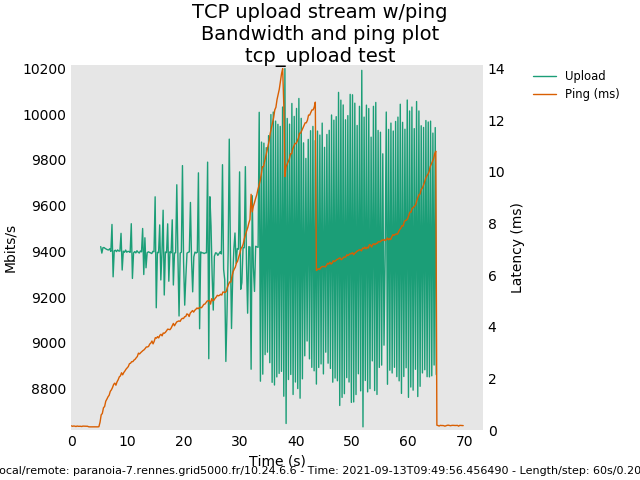

In [15]:
from IPython.display import Image
Image(f"result/{roles['client'][0].alias}/result_bind.png")

## Checking that the network traffic flows through the right interface :)

In [16]:
# we enable the statistics on all known interfaces
# note that this seems incompatible with --epoch :( :(
with en.Dstat(nodes=roles["xp"], options="--full") as d:
    backup_dir = d.backup_dir
    with en.actions(pattern_hosts="server", roles=roles) as a:
        a.shell("netperf", background=True) # this is somehow idempotent .. will fail silently if netperf is already started
        a.wait_for(port=12865, state="started", task_name="Waiting for netperf to be ready")


    with en.actions(pattern_hosts="client", roles=roles) as a:
        a.shell(
            " flent tcp_upload -p totals "
            " -l 60 "
            f" -H { server_address } "
            "--local-bind {{ local_bind }} "
            " -t 'tcp_upload test' "
            " -o result_bind.png"
        )
        a.fetch(src="result_bind.png", dest="result")


PLAY [all] **********************************************************************************************************************************************************************************

TASK [(tmux list-panes -t __enoslib_dstat__ -F '#{pane_pid}' | xargs -n1 kill -2) || true] **************************************************************************************************
 [started TASK: (tmux list-panes -t __enoslib_dstat__ -F '#{pane_pid}' | xargs -n1 kill -2) || true on paravance-6.rennes.grid5000.fr]
 [started TASK: (tmux list-panes -t __enoslib_dstat__ -F '#{pane_pid}' | xargs -n1 kill -2) || true on paranoia-7.rennes.grid5000.fr]
changed: [paranoia-7.rennes.grid5000.fr]
changed: [paravance-6.rennes.grid5000.fr]

PLAY [all] **********************************************************************************************************************************************************************************

TASK [apt] ***************************************************************

[WARNING]: Module remote_tmp /root/.ansible/tmp did not exist and was created with a mode of 0700, this may cause issues when running as another user. To avoid this, create the remote_tmp
dir with the correct permissions manually


changed: [paranoia-7.rennes.grid5000.fr]
changed: [paravance-6.rennes.grid5000.fr]

TASK [Running dstat with the options --full -o 1631519468386122672-dstat.csv] ***************************************************************************************************************
 [started TASK: Running dstat with the options --full -o 1631519468386122672-dstat.csv on paravance-6.rennes.grid5000.fr]
 [started TASK: Running dstat with the options --full -o 1631519468386122672-dstat.csv on paranoia-7.rennes.grid5000.fr]
changed: [paravance-6.rennes.grid5000.fr]
changed: [paranoia-7.rennes.grid5000.fr]

PLAY [server] *******************************************************************************************************************************************************************************

TASK [netperf] ******************************************************************************************************************************************************************************
 [started TASK: ne

In [17]:
import pandas as pd
import seaborn as sns 

print(backup_dir)

# create a dictionnary: host -> pd.DataFrame
results = dict()
for host in roles["xp"]:
    result = pd.DataFrame()
    host_dir = backup_dir / host.alias
    csvs = host_dir.rglob("*.csv")
    for csv in csvs:
        print(csv)
        df = pd.read_csv(csv, skiprows=5, index_col=False)
        df["host"] = host.alias
        df["csv"] = csv
        result = pd.concat([result, df], axis=0)
    results[host] = result

/home/msimonin/workspace/repos/enoslib/docs/jupyter/__enoslib_dstat__/1631519468386122672
/home/msimonin/workspace/repos/enoslib/docs/jupyter/__enoslib_dstat__/1631519468386122672/paravance-6.rennes.grid5000.fr/tmp/__enoslib_dstat__/1631519468386122672/1631519468386122672-dstat.csv
/home/msimonin/workspace/repos/enoslib/docs/jupyter/__enoslib_dstat__/1631519468386122672/paranoia-7.rennes.grid5000.fr/tmp/__enoslib_dstat__/1631519468386122672/1631519468386122672-dstat.csv


In [18]:
results[roles["xp"][0]]

,usr,sys,idl,wai,stl,dsk/sda:read,dsk/sda:writ,dsk/sdb:read,dsk/sdb:writ,net/eno1:recv,net/eno1:send,net/eno2:recv,net/eno2:send,1m,5m,15m,time,host,csv
0,0.592,0.655,97.971,0.782,0,611202.145,3.285433e+06,5460.249,0,0,0,0,0,0.62,0.59,0.31,Sep-13 09:51:16,paravance-6.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
1,0.000,0.031,99.062,0.906,0,0.000,4.970906e+07,0.000,0,94028,4278,0,0,0.57,0.58,0.31,Sep-13 09:51:17,paravance-6.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
2,1.530,1.437,97.033,0.000,0,4096.000,0.000000e+00,0.000,0,185850,5560,0,0,0.57,0.58,0.31,Sep-13 09:51:18,paravance-6.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
3,1.894,4.564,93.480,0.062,0,0.000,2.048000e+05,0.000,0,150,90,196,196,0.57,0.58,0.31,Sep-13 09:51:19,paravance-6.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
4,1.651,4.517,93.832,0.000,0,0.000,0.000000e+00,0.000,0,60,0,490,490,0.57,0.58,0.31,Sep-13 09:51:20,paravance-6.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.000,0.000,100.000,0.000,0,0.000,0.000000e+00,0.000,0,60,0,490,490,0.48,0.56,0.32,Sep-13 09:52:27,paravance-6.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
72,0.000,0.000,100.000,0.000,0,0.000,0.000000e+00,0.000,0,120,0,490,490,0.48,0.56,0.32,Sep-13 09:52:28,paravance-6.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
73,0.000,0.000,100.000,0.000,0,0.000,3.276800e+04,0.000,0,60,0,294,294,0.48,0.56,0.32,Sep-13 09:52:29,paravance-6.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...
74,0.000,0.000,100.000,0.000,0,0.000,0.000000e+00,0.000,0,0,0,60,0,0.48,0.56,0.32,Sep-13 09:52:30,paravance-6.rennes.grid5000.fr,/home/msimonin/workspace/repos/enoslib/docs/ju...


['net/eno2:recv', 'net/eno2:send', 'net/eno1:recv', 'net/eno1:send']
['net/enp3s0f0:recv', 'net/enp3s0f0:send', 'net/enp3s0f1:recv', 'net/enp3s0f1:send']


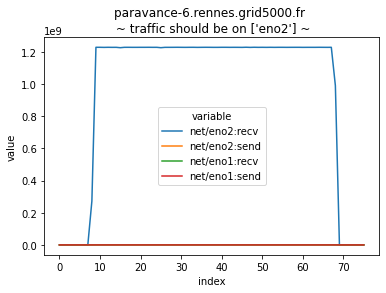

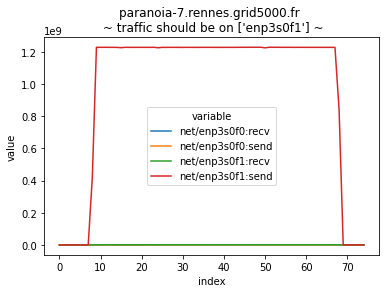

In [19]:
from itertools import product
import matplotlib.pyplot as plt 

for host, result in results.items():
    interfaces = host.filter_interfaces()
    # interfaces = [eno1, enos2]
    keys_in_csv = [fmt % interface for interface, fmt in product(interfaces, ["net/%s:recv", "net/%s:send"])]
    # keys_in_csv = ['net/eno2:recv', 'net/eno2:send', 'net/eno1:recv', 'net/eno1:send']
    print(keys_in_csv)
    plt.figure()
    # melt makes the data tidy
    # 0, {recv, send}, value_0
    # 1, {recv, send}, value_1
    sns.lineplot(data=result.melt(value_vars = keys_in_csv, ignore_index=False).reset_index(), x="index", y="value", hue="variable")
    plt.title(f"{host.alias} \n ~ traffic should be on {host.filter_interfaces(networks=networks['private'])} ~")

## Emulating the network conditions

We'll illustrate how network constraints can be set on specific network interfaces on the nodes of the experiment.
To do so EnOSlib provides two services:
- the Netem service which is a wrapper around [netem](https://wiki.linuxfoundation.org/networking/netem).
- the NetemHTB which provides a high level interface to finer grained [HTB network based emulation](https://tldp.org/HOWTO/Traffic-Control-HOWTO/classful-qdiscs.html)

More information can be found in the EnOSlib documentation:  https://discovery.gitlabpages.inria.fr/enoslib/apidoc/netem.

EnOSlib let's you set the constraint easily on a dedicated network by only specifying it with its logical name.

In [20]:
netem = en.Netem()
# symetric constraints:
# node1|10ms ---> 10ms|node2|10ms --> 10ms|node1
netem.add_constraints("delay 10ms", roles["xp"], symetric=True, networks=networks["private"])

device,direction,options
eno2,in,delay 10ms
eno2,out,delay 10ms
device,direction,options
enp3s0f1,in,delay 10ms
enp3s0f1,out,delay 10ms


In [21]:
netem.deploy()


PLAY [all] **********************************************************************************************************************************************************************************

TASK [Applying the network constraints] *****************************************************************************************************************************************************
 [started TASK: Applying the network constraints on paravance-6.rennes.grid5000.fr]
 [started TASK: Applying the network constraints on paranoia-7.rennes.grid5000.fr]
changed: [paravance-6.rennes.grid5000.fr] => (item=tc qdisc del dev eno2 root || true ; tc qdisc del dev eno2 root || true ; tc qdisc del dev ifb1 root ; tc qdisc add dev eno2 root netem delay 10ms ; tc qdisc add dev eno2 ingress ; ip link add ifb1 type ifb ; ip link set dev ifb1 up ; tc filter add dev eno2 parent ffff: protocol ip u32 match u32 0 0 flowid 1:1 action mirred egress redirect dev ifb1 ; tc qdisc add dev ifb1 root netem delay 10ms)
ch

---
There's a convenient method that let you quickly check the network condition (at least the RTT latency)

In [22]:
netem.validate()


PLAY [Gather facts for all hosts] ***********************************************************************************************************************************************************

TASK [Gathering Facts] **********************************************************************************************************************************************************************
ok: [paravance-6.rennes.grid5000.fr]
ok: [paranoia-7.rennes.grid5000.fr]

TASK [setup] ********************************************************************************************************************************************************************************
ok: [paravance-6.rennes.grid5000.fr]
ok: [paranoia-7.rennes.grid5000.fr]

PLAY [Utils functions] **********************************************************************************************************************************************************************

TASK [Gathering Facts] ******************************************************************

In [27]:
from pathlib import Path
server_alias = roles['server'][0].alias
print(server_alias)
print(Path(f"_tmp_enos_/{server_alias}.out").read_text())

print("...8<"*20)
client_alias = roles['client'][0].alias
print(client_alias)

print(Path(f"_tmp_enos_/{client_alias}.out").read_text())

paravance-6.rennes.grid5000.fr
10.24.4.7    : 40.31 40.41 40.37 40.38 40.40 40.35 40.38 40.31 40.32 40.33
10.24.6.6    : 0.02 0.03 0.02 0.01 0.02 0.02 0.02 0.02 0.02 0.02
172.16.96.6  : 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.02 0.02
172.16.100.7 : 0.34 0.20 0.15 0.16 0.18 0.15 0.15 0.14 0.17 0.15

       4 targets
       4 alive
       0 unreachable
       0 unknown addresses

       0 timeouts (waiting for response)
      40 ICMP Echos sent
      40 ICMP Echo Replies received
       0 other ICMP received

 0.01 ms (min round trip time)
 10.1 ms (avg round trip time)
 40.4 ms (max round trip time)
        9.049 sec (elapsed real time)


...8<...8<...8<...8<...8<...8<...8<...8<...8<...8<...8<...8<...8<...8<...8<...8<...8<...8<...8<...8<
paranoia-7.rennes.grid5000.fr
10.24.4.7    : 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
10.24.6.6    : 40.37 40.42 40.41 40.42 40.41 40.42 40.41 40.42 40.41 40.37
172.16.96.6  : 0.12 0.14 0.15 0.14 0.16 0.15 0.17 0.18 0.17 0.14
172.16.100.7 : 0

## Clean

In [28]:
provider.destroy()

INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from grenoble
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from lille
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from luxembourg
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from lyon
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from nancy
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from nantes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading 1818299 from rennes
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Reloading enoslib_several_networks from sophia
INFO:enoslib.infra.enos_g5k.g5k_api_utils:Killing the job (rennes, 1818299)
